# La costruzione, l'addestramento, e il funzionamento di una semplice rete neurale per leggere cifre scritte a mano
Luca Mari, aprile 2025

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: comprendere la struttura di una semplice rete neurale, il suo addestramento e il suo funzionamento, per come specificati in Python mediante un modulo di alto livello come `PyTorch`.    
**Precompetenze**: eventuali basi di Python (il codice Python è ovunque semplice, perché richiama funzioni che nascondono molti dettagli, salvo che in alcuni punti in cui i dettagli stessi sono considerati di particolare interesse).

> Per eseguire questo notebook, supponiamo con VSCode, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>    * creare una cartella di lavoro e renderla la cartella corrente
>    * copiare nella cartella i file di questa attività: [mnist.ipynb](mnist.ipynb) e [mnistutils.py](mnistutils.py)
>     * aprire il notebook `mnist.ipynb`
>    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>    * installare i moduli Python richiesti, eseguendo dal terminale:  
>        `pip install torch torchvision matplotlib`

**Indice**  
[1. Il problema](#s1)  
[2. Il dataset](#s2)  
[3. La costruzione della rete](#s3)  
[4. L'addestramento della rete](#s4)  
[5. Il funzionamento della rete](#s5)  
[6. Un'analisi del comportamento della rete](#s6)

### 1. Il problema
<a id="s1"></a>

Vogliamo costruire una rete neurale che sappia riconoscere cifre scritte a mano. A questo scopo, sia per addestrare la rete sia poi per metterla alla prova useremo [il dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database), che contiene appunto immagini di cifre scritte a mano, e per ognuna l'informazione di quale cifra è scritta.  
Si tratta perciò di un problema di classificazione: per ogni immagine che le è sottoposta, la rete deve trovare a quale delle 10 classi appartiene: 0, 1, ..., 9.

Ogni immagine nel dataset è digitalizzata in una matrice di 28x28 = 784 punti e ogni punto ha un colore nella scala dei grigi, codificato in 8 bit, cioè 1 byte; ogni immagine corrisponde a una delle possibili 10 cifre: 0, 1, ..., 9.  
Dunque la rete ha il compito di accettare in input un vettore di circa 1000 numeri tra 0 e 255 e di produrre in output un numero tra 0 e 9.

<a id="s2"></a>
### 2. Il dataset

Dopo aver importato i moduli Python necessari, recuperiamo dal web il dataset, distinguendo tra _training set_ e _test set_.  
Il primo ci servirà per addestrare la rete, il secondo per metterla alla prova, ovviamente con immagini diverse da quelle con cui era stata addestrata per assicurarci che se la rete sarà capace di riconoscere correttamente le immagini non è perché ha memorizzato quanto le è stato mostrato durante l'addestramento.

In [3]:
from mnistutils import load_data, load_batch, show_images, train_loop, test_loop, test_with_prob, test_loop_with_trace
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random
import time

train_data, test_data = load_data()

print(f'Il training set contiene {len(train_data)} immagini')
print(f'e il test set contiene {len(test_data)} immagini.')

Il training set contiene 60000 immagini
e il test set contiene 10000 immagini.


Ora che il dataset è disponibile, possiamo mostrare qualche esempio delle immagini che contengono le cifre che vogliamo addestrare la rete a riconoscere, insieme con l'indicazione della cifre corretta, informazione anch'essa contenuta nei file che abbiamo scaricato.

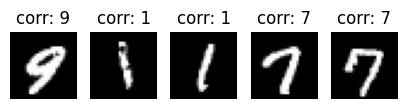

In [14]:
n = 5
random_indexes = [random.randint(0, len(train_data)) for _ in range(n)]
show_images(train_data, random_indexes)

La varietà e l'irregolarità della scrittura a mano in queste immagini suggeriscono che ideare un algoritmo per risolvere il nostro problema di classificazione e poi implementarlo in un programma potrebbe essere estremamente complesso, come infatti confermano i limitati risultati ottenuti dai sistemi software sviluppati in accordo a questa strategia.

<a id="s3"></a>
### 3. La costruzione della rete

Cerchiamo dunque invece di risolvere il problema con la logica del _machine learning_, costruendo e poi addestrando una rete neurale. Lo faremo partendo da una rete con una struttura molto semplice (un _MultiLayer Perceptron_, MLP), organizzata in "strati" (_layer_):
* lo _strato di input_ realizza un "occhio artificiale" con 28x28 punti sensibili, tanti quanti punti ha ogni immagine da classificare; ogni volta che viene sottoposta un'immagine alla rete, ognuno di questi punti sensibili assume il valore corrispondente al colore di un punto dell'immagine;
* lo _strato di output_ contiene 10 neuroni, uno per ogni possibile classe in cui classificare un'immagine, e quindi uno per ogni possibile cifra riconoscibile; ogni volta che viene sottoposta un'immagine alla rete e la rete viene fatta funzionare, ognuno di questi neuroni dovrà assumere come valore la probabilità che l'immagine contenga la cifra corrispondente, e quindi complessivamente i valori dei 10 neuroni sono una distribuzione di probabilità sull'insieme 0, 1, ..., 9;
* tra lo strato di input e quello di output introduciamo un "cervello" realizzato con _strati interni_ (in inglese: _hidden layer_): manterremo questo esempio assai semplice, con un solo strato interno con soli 10 neuroni.

La parte davvero importante di questa rete sono le sue "sinapsi", cioè le connessioni tra i neuroni, perché sono esse a essere adattabili, in quanto parametri della funzione realizzata dalla rete stessa. È grazie a esse che durante l'addestramento la rete può modificare il suo comportamento e imparare a classificare le immagini.  
In questa rete ogni neurone di uno strato è collegato a ogni neurone dello strato successivo, e quindi con qualche moltiplicazione è facile calcolare quanti parametri ha la rete.

Questa è dunque la struttura della rete:  

![rete](mnist_simple.drawio.svg)

In accordo a queste indicazioni costruiamo finalmente la rete.

In [15]:
class MLP_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()     # Flatten() rende unidimensionale l'input, adattando così le immagini allo strato di input
        self.inner_layer = nn.Linear(28*28, 10) # Linear(x, y) costruisce la connessione tra tutti gli x neuroni di uno strato e gli y neuroni dello strato successivo
        self.activation = nn.ReLU()     # ReLU() è una funzione di attivazione che restituisce 0 se l'input è negativo e l'input stesso altrimenti
        self.output_layer = nn.Linear(10, 10)

        self.network = nn.Sequential(   # Sequential() costruisce la rete come una composizione funzionale di componenti
            self.flatten,
            self.inner_layer,
            self.activation,            
            self.output_layer           # per efficienza, la rete restituisce i logits e non le probabilità
        )

    def forward(self, x):
        return self.network(x)

network = MLP_NN()

num_MLP_params = sum(p.numel() for p in network.parameters())
print(f"Abbiamo costruito una rete con {num_MLP_params} parametri.")

Abbiamo costruito una rete con 7960 parametri.


Già ora possiamo far funzionare la rete, ancora prima di averla addestrata e quindi con i suoi parametri inizializzati a valori casuali. Per ogni immagine scelta a caso, la rete produce una funzione di logits, normalizzata a distribuzione di probabilità mediante Softmax, e da questa scegliamo come cifra prevista ("prev") quella più probabile nella distribuzione. Ma la distribuzione che otteniamo è praticamente uniforme, cioè è in condizioni "di minima informazione" (e quindi di massima ignoranza / entropia): come ci potevamo aspettare, senza addestramento la rete non è in grado di fare nulla di utile.

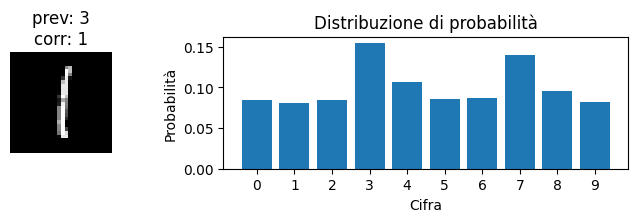

In [21]:
test_with_prob(test_data, random.randint(0, len(test_data)), network)

<a id="s4"></a>
### 4. L'addestramento della rete

È dunque il momento di progettare l'addestramento della rete, e per questo dobbiamo prima di tutto decidere "il programma scolastico": gli iperparametri dell'addestramento e le funzioni per la _backpropagation_.

In [22]:
learning_rate = 1e-3                    # velocità di apprendimento
batch_size = 100                        # numero di immagini per gruppo
num_batches = 500                       # numero di gruppi di immagini per epoca
epochs = 20                             # numero di epoche

loss_fn = nn.CrossEntropyLoss()         # funzione per calcolare gli errori
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate) # funzione per correggere gli errori # type: ignore

A questo punto possiamo finalmente "mandare a scuola" la rete. E alla fine di ogni "giorno di scuola" la sottoponiamo a una prova, per valutare se sta imparando a classificare correttamente le immagini.

In [23]:
print("Epoca\tAccuratezza")
correct = test_loop(test_data, batch_size, network) / batch_size * 100
print(f"0\t{correct:.0f}%")

start_time = time.time()
accuracy = []
for t in range(epochs):
    train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network) / batch_size * 100
    print(f"{t + 1}\t{correct:.0f}%")
    accuracy.append(correct)
end_time = time.time()

print(f"Addestramento completato in {end_time - start_time:.0f} secondi")

Epoca	Accuratezza
0	5%
1	16%
2	25%
3	36%
4	39%
5	37%
6	49%
7	47%
8	60%
9	75%
10	74%
11	80%
12	81%
13	80%
14	73%
15	84%
16	83%
17	77%
18	83%
19	82%
20	82%
Addestramento completato in 53 secondi


Visualizzando in un grafico i valori di accuratezza durante l'addestramento vediamo che il processo non è deterministico, e ciò a causa del fatto che la difficoltà di riconoscimento non è la stessa per tutte le immagini.

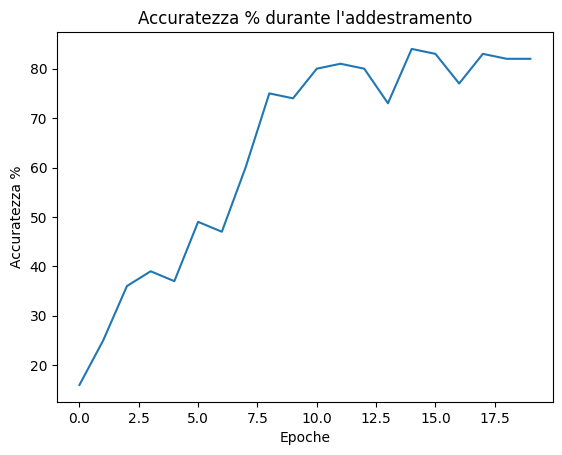

In [24]:
plt.plot(range(epochs), accuracy)
plt.xlabel('Epoche')
plt.ylabel('Accuratezza %')
plt.title("Accuratezza % durante l'addestramento")
plt.show()

In [10]:
# salvataggio del modello
torch.save(network.state_dict(), 'data/model.pth')

In [5]:
# caricamento del modello
network = MLP_NN()
network.load_state_dict(torch.load('data/model.pth'))

<All keys matched successfully>

<a id="s5"></a>
### 5. Il funzionamento della rete

Ora che la rete è addestrata, la possiamo far funzionare, e valutare l'accuratezza delle sue classificazioni, ovviamente sempre in riferimento a immagini del _test set_, su cui non era stata addestrata.

In [14]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network) / batch_size * 100
print(f"Accuratezza: {correct:.1f}%")

Accuratezza: 84.4%


Possiamo anche valutare qualitativamente il comportamento della rete confrontando la cifra prevista e quella corretta per $n$ immagini prese a caso dal _test set_.

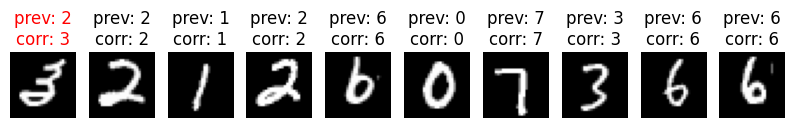

In [16]:
n = 10
random_indexes = [random.randint(0, len(test_data)) for _ in range(n)]
test_loop_with_trace(test_data, random_indexes, network)

E possiamo visualizzare la distribuzione di probabilità prodotta come risultato dell'elaborazione di una singola immagine. È qui evidente l'effetto dell'addestramento: anche se la struttura della rete non è cambiata, e dunque non abbiamo modificato la rete riprogrammandola, la distribuzione non è più uniforme, ma ha generalmente una o poche categorie a probabilità elevata. Insomma, questa significativa differenza di comportamento è interamente dovuta all'addestramento a cui abbiamo sottoposto la rete.

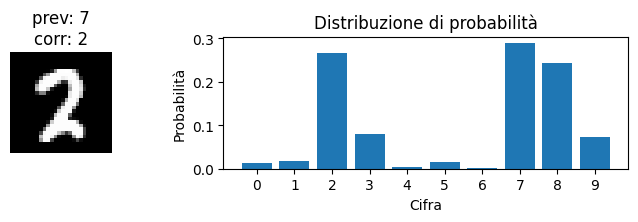

In [34]:
random_index = random.randint(0, len(test_data))
test_with_prob(test_data, random_index, network)

<a id="s6"></a>
### 6. Un'analisi del comportamento della rete

Ora che la rete è addestrata, possiamo metterla alla prova, per cercare di capire meglio _come funziona_.

Prima di tutto e ancora solo qualitativamente, scegliamo una cifra e vediamo come la rete si comporta nel riconoscimento di immagini di quella cifra scelte casualmente:

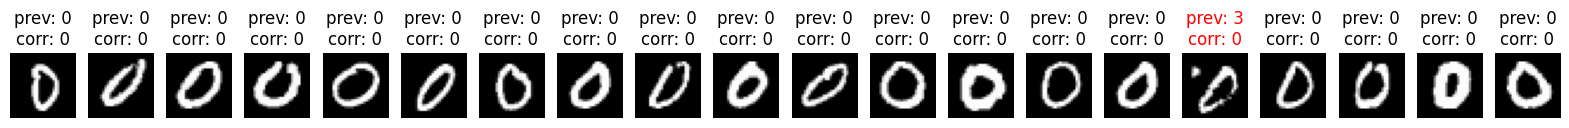

In [20]:
to_test = 0                             # cifra da mettere alla prova
num_images = 20                         # numero di immagini da mostrare
k_data = [data for data in test_data if data[1] == to_test]
random_indexes = [random.randint(0, len(k_data)) for _ in range(num_images)]
test_loop_with_trace(k_data, random_indexes, network)

Per cominciare a rendere l'analisi un poco più sistematica, per ognuna delle 10 cifre contiamo quante immagini ci sono nel _test set_ e calcoliamo la percentuale di immagini riconosciute correttamente. In questo modo si evidenzia se ci sono cifre che la rete fa più fatica a riconoscere. 

In [35]:
print("Cifra\tn. imm\t% corrette")
network.eval()
for k in range(10):
    k_data = [data for data in test_data if data[1] == k]
    with torch.no_grad():
        X, y = load_batch(k_data)
        Y = network(X).argmax(1)
        correct = (Y == y).type(torch.float).sum().item()
    print(f"{k}\t{len(k_data)}\t{100*correct/len(k_data):.1f}%")

Cifra	n. imm	% corrette
0	980	95.0%
1	1135	96.0%
2	1032	80.9%
3	1010	85.0%
4	982	83.9%
5	892	57.4%
6	958	88.7%
7	1028	87.5%
8	974	77.3%
9	1009	82.4%


Operiamo ora in modo più sistematico: ripetiamo più volte l'addestramento della rete, re-inizializzandola ogni volta, e poi calcolando la percentuale di immagini riconosciute correttamente per ogni cifra, per studiare quanto il comportamento della rete sia robusto, cifra per cifra, al variare del suo addestramento.

In [12]:
num_tests = 20                           # numero di prove
results = np.zeros((10, num_tests))

for test in range(num_tests):
    network = MLP_NN()
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    network.train()
    print(f"\nTraining {test + 1} (epoche): ", end='')
    for t in range(epochs):
        train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
        print(t + 1, end=' ')
    network.eval()
    print("\n    Testing (cifre): ", end='')
    for k in range(10):
        k_data = [data for data in test_data if data[1] == k]
        with torch.no_grad():
            X, y = load_batch(k_data)
            Y = network(X).argmax(1)
            correct = 100 * ((Y == y).type(torch.float).sum().item()) / len(k_data)
            results[k, test] = correct
            print(k + 1, end=' ')


Training 1 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 2 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 3 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 4 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 5 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 6 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 7 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 8 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Testing (cifre): 1 2 3 4 5 6 7 8 9 10 
Training 9 (epoche): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

In [ ]:
means = results.mean(axis=1)
stdevs = results.std(axis=1)
print("Percentuali di correttezza per cifra")
print("cifra\tmedia\tdeviazione standard")
for k in range(10):
    print(f"{k}\t{means[k]:.1f}\t{stdevs[k]:.1f}")

Percentuali di correttezza per cifra
Cifra	media	deviazione standard
0	94.7	1.7
1	95.9	1.1
2	80.3	2.5
3	84.3	2.8
4	79.0	12.6
5	61.9	6.9
6	89.2	1.1
7	85.9	2.0
8	76.3	5.6
9	76.9	3.3


Appare chiaro che il comportamento della rete non è omogeneo per cifre diverse. In particolare, ci sono cifre (come 0 e 1) che sono riconosciute costantemente con grande accuratezza e altre cifre (come 4 e 5) il cui riconoscimento ha un'accuratezza minore e che inoltre varia in modo significativo ripetendo l'addestramento. 

Di nuovo per una cifra data, osserviamo i valori che i neuroni dello strato interno della rete producono quando vengono sottoposte alla rete delle immagini di quella cifra scelte casualmente:

Riconoscimenti corretti: 4/5

Output dei 10 neuroni interni per 5 immagini casuali della cifra 0
neurone	media	deviazione standard
0	5.4	2.4
1	0.4	0.5
2	1.9	0.4
3	4.5	1.5
4	1.7	0.7
5	0.4	0.6
6	1.2	0.3
7	1.2	1.0
8	1.8	1.0
9	1.3	0.5


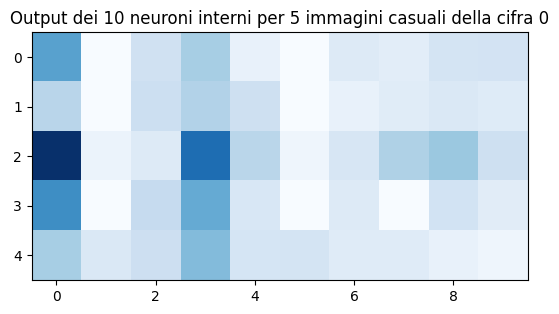

In [52]:
to_test = 0                             # cifra da mettere alla prova
num_images = 5                          # numero di immagini da mostrare
activations = np.zeros((num_images, 10))
num_correct = 0
k_data = [data for data in test_data if data[1] == to_test]
random_indexes = [random.randint(0, len(k_data)) for _ in range(num_images)]
network.eval()
with torch.no_grad():
    for i in range(num_images):
        Y = network.flatten(k_data[random_indexes[i]][0])
        Y = network.inner_layer(Y)
        Y = network.activation(Y)
        activations[i] = Y[0].numpy()
        Y = network.output_layer(Y)
        Y = nn.Softmax(dim=1)(Y).argmax(1)
        if Y == to_test: num_correct += 1

print(f"Riconoscimenti corretti: {num_correct}/{num_images}\n")

means = activations.mean(axis=0)
stdevs = activations.std(axis=0)
print(f"Output dei 10 neuroni interni per {num_images} immagini casuali della cifra {to_test}")
print("neurone\tmedia\tdeviazione standard")
for k in range(10):
    print(f"{k}\t{means[k]:.1f}\t{stdevs[k]:.1f}")

plt.imshow(activations, cmap='Blues')
plt.title(f"Output dei 10 neuroni interni per {num_images} immagini casuali della cifra {to_test}")
plt.show()

Riconoscimenti corretti: 5/5



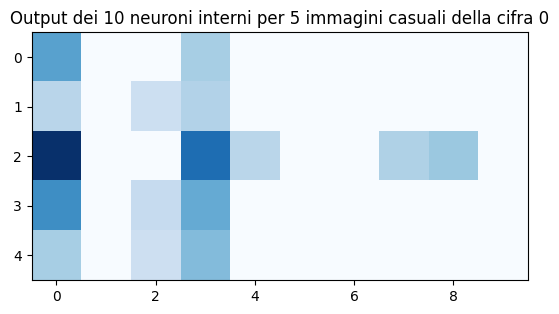

In [53]:
forced_activations = np.zeros((num_images, 10))
num_correct = 0
network.eval()
with torch.no_grad():
    for i in range(num_images):
        Y = network.flatten(k_data[random_indexes[i]][0])
        Y = network.inner_layer(Y)
        Y = network.activation(Y)
        Y[0] = torch.where(Y[0] > 2, Y[0], 0)
        forced_activations[i] = Y[0].numpy()
        Y = network.output_layer(Y)
        Y = nn.Softmax(dim=1)(Y).argmax(1)
        if Y == to_test: num_correct += 1

print(f"Riconoscimenti corretti: {num_correct}/{num_images}\n")

plt.imshow(forced_activations, cmap='Blues')
plt.title(f"Output dei 10 neuroni interni per {num_images} immagini casuali della cifra {to_test}")
plt.show()